In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier

from time import time

pd.set_option('display.precision', 3)
np.set_printoptions(suppress=True, precision=3)

prng = np.random.RandomState(20250324)

# Introduction to Neural networks

## Recap from last class: MNIST digits

X_train_full: (60000, 28, 28)
y_train_full: (60000,)
X_test_full:  (10000, 28, 28)
y_test_full:  (10000,)


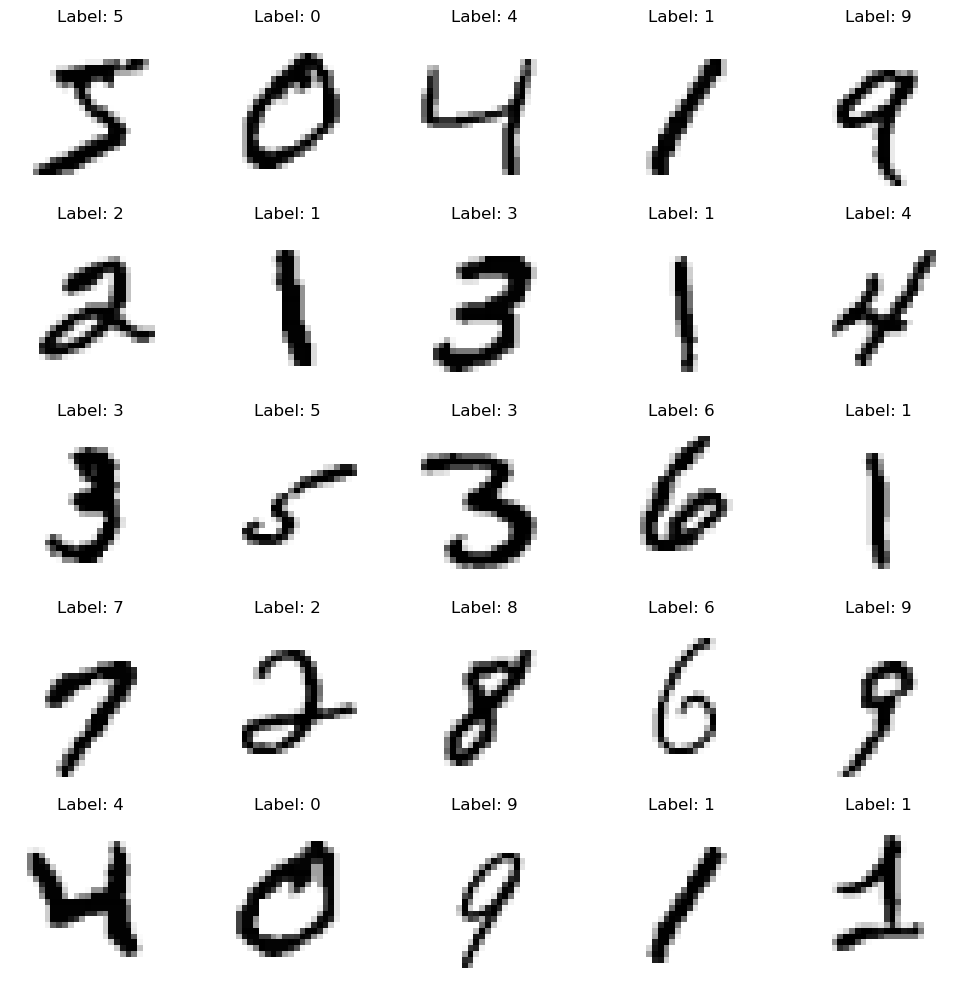

In [2]:
# Load MNIST dataset from Keras
from tensorflow.keras.datasets import mnist

# Load data with predefined train/test split
(X_train_full, y_train_full), (X_test, y_test) = mnist.load_data()

# Look at the dimensions
print(f"X_train_full: {X_train_full.shape}")
print(f"y_train_full: {y_train_full.shape}")
print(f"X_test_full:  {X_test.shape}")
print(f"y_test_full:  {y_test.shape}")

fig, axs = plt.subplots(5, 5, figsize=(10,10))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(X_train_full[i], cmap="binary")
    ax.axis("off")
    ax.set_title(f"Label: {y_train_full[i]}")
plt.tight_layout()
plt.show()

In [3]:
# Define preprocessing step: rescale and flatten
def preprocessImageData(X):
    return X.reshape(X.shape[0], -1) / 255

## Benchmark: logistic regression

[Note that regularization is applied by default.](https://arc.net/l/quote/ndorcdmu)

In [4]:
pipe_lr_full = Pipeline([
    ("preprocess", FunctionTransformer(preprocessImageData)),
    ("lr", LogisticRegression(max_iter=1000, random_state=prng))
])

time0 = time()
pipe_lr_full.fit(X_train_full, y_train_full)
time_full = time() - time0
print(f"Logistic regression on full data completed in {time_full:.2f} seconds")

pipe_lr_pca = Pipeline([
    ("preprocess", FunctionTransformer(preprocessImageData)),
    ("pca", PCA(n_components=0.95)),
    ("lr", LogisticRegression(max_iter=1000, random_state=prng))
])

time0 = time()
pipe_lr_pca.fit(X_train_full, y_train_full)
time_pca = time() - time0
print(f"Logistic regression on PCA data completed in {time_pca:.2f} seconds")

Logistic regression on full data completed in 17.10 seconds
Logistic regression on PCA data completed in 2.78 seconds


In [5]:
# Compare performance metrics
performance_summary_data = {
    'Metric': ['Dimensions', 'Fit time', 'Accuracy (training)', 'Accuracy (validation)'],
    'Full data': [pipe_lr_full['lr'].n_features_in_, time_full, pipe_lr_full.score(X_train_full, y_train_full), pipe_lr_full.score(X_test, y_test)],
    'PCA': [pipe_lr_pca['lr'].n_features_in_, time_pca, pipe_lr_pca.score(X_train_full, y_train_full), pipe_lr_pca.score(X_test, y_test)],
}
performance_summary_df = pd.DataFrame(performance_summary_data)
print(performance_summary_df)

                  Metric  Full data      PCA
0             Dimensions    784.000  154.000
1               Fit time     17.104    2.777
2    Accuracy (training)      0.939    0.927
3  Accuracy (validation)      0.926    0.923


### Combine unsupervised and supervised learning methods: impact of PC components on performance metrics

In [6]:
# Decrease the data to quicken up computation (split should be preserved across notebooks)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, train_size=10000, random_state=20250324, stratify=y_train_full)

In [7]:
# Try different numbers of PCA components to see impact on accuracy
pca_components = [5, 10, 20, 30, 50, 75, 100, 150, 200, 400, 784]
accuracies = []
val_accuracies = []
times = []

# Scale separately (so that it should not run again and again)
X_scaled = pipe_lr_pca['preprocess'].transform(X_train)
X_scaled_val = pipe_lr_pca['preprocess'].transform(X_val)

for n_components in pca_components:

    pipe = Pipeline([
        ('pca', PCA(n_components=n_components)),
        ('lr', LogisticRegression(max_iter=1000, random_state=prng))
    ])

    # Fit the model
    t0 = time()
    pipe.fit(X_scaled, y_train)
    time_fit = time() - t0
    
    # Calculate accuracy
    acc = accuracy_score(y_train, pipe.predict(X_scaled))
    validation_acc = accuracy_score(y_val, pipe.predict(X_scaled_val))
    
    # Store results
    times.append(time_fit)
    accuracies.append(acc)
    val_accuracies.append(validation_acc)

In [8]:
best_n_pca = pca_components[np.argmax(val_accuracies)]
print(f"Best validation accuracy is achieved with {best_n_pca} components.")

Best validation accuracy is achieved with 100 components.


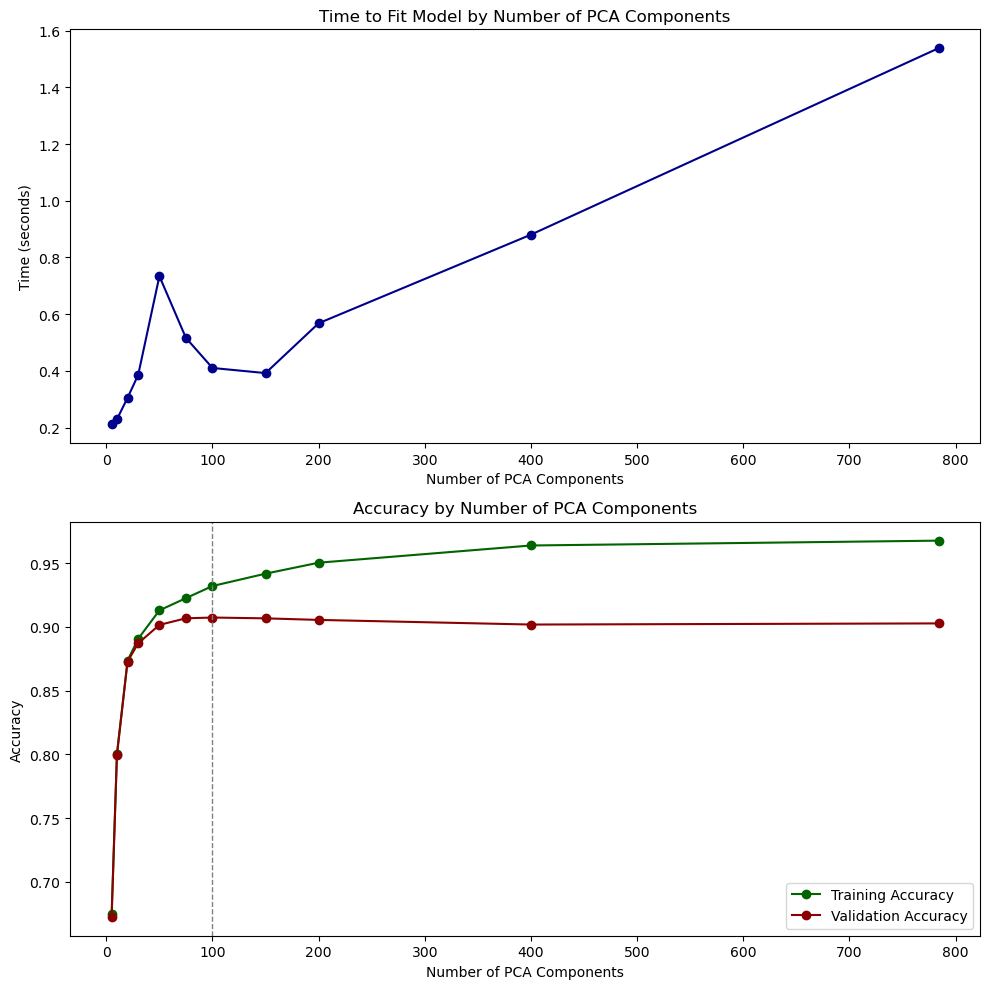

In [9]:
# Visualize the results

fig, ax = plt.subplots(2, 1, figsize=(10, 10))

# First plot: times by PCA components
ax[0].plot(pca_components, times, marker='o', color='darkblue')
ax[0].set_title('Time to Fit Model by Number of PCA Components')
ax[0].set_xlabel('Number of PCA Components')
ax[0].set_ylabel('Time (seconds)')

# Second plot: accuracies and val_accuracies by PCA components
ax[1].plot(pca_components, accuracies, marker='o', color='darkgreen', label='Training Accuracy')
ax[1].plot(pca_components, val_accuracies, marker='o', color='darkred', label='Validation Accuracy')
ax[1].set_title('Accuracy by Number of PCA Components')
ax[1].set_xlabel('Number of PCA Components')
ax[1].set_ylabel('Accuracy')
ax[1].legend()
ax[1].axvline(x=best_n_pca, color='gray', linestyle='--', linewidth=1)


plt.tight_layout()
plt.show()

### Store results (smaller dataset)

In [10]:
class ResultCollector:
    def __init__(self):
        self.results = {}
        
    def add_model(self, name, train_acc, test_acc):
        """Add or update a model's results."""
        self.results[name] = {
            'Train Accuracy': train_acc,
            'Test Accuracy': test_acc
        }
        return self.get_table()
    
    def get_table(self):
        """Get the results table with optional styling."""
        df = pd.DataFrame(self.results).T
        return df.style.format("{:.3f}").background_gradient(cmap='RdYlGn', axis=None)

In [11]:
# Refit the full Logistic Regression pipeline on the sampled data
pipe_lr_full.fit(X_train, y_train)
train_accuracy = accuracy_score(pipe_lr_full.predict(X_train), y_train)
test_accuracy = accuracy_score(pipe_lr_full.predict(X_val), y_val)

In [12]:
results = ResultCollector()
results.add_model("Logistic Regression", train_accuracy, test_accuracy)

,Train Accuracy,Test Accuracy
Logistic Regression,0.967,0.902


In [13]:
pipe_pca = Pipeline([
    ("preprocess", FunctionTransformer(preprocessImageData)),
    ("pca", PCA(n_components=best_n_pca)),
    ("lr", LogisticRegression(max_iter=1000, random_state=prng))
])
pipe_pca.fit(X_train, y_train)
train_accuracy = accuracy_score(pipe_pca.predict(X_train), y_train)
test_accuracy = accuracy_score(pipe_pca.predict(X_val), y_val)

results.add_model("Logistic Regression with PCA", train_accuracy, test_accuracy)


,Train Accuracy,Test Accuracy
Logistic Regression,0.967,0.902
Logistic Regression with PCA,0.932,0.907


In [14]:
X_train.shape

(10000, 28, 28)

In [15]:
y_train.shape

(10000,)

In [17]:
y_train[0], y_train[1]

(np.uint8(1), np.uint8(3))

In [25]:
pipe_lr_full.predict_proba(X_val)[0]

array([0.112, 0.   , 0.254, 0.626, 0.   , 0.001, 0.   , 0.   , 0.006,
       0.   ])

## Benchmark #2: Random Forest (state-of-the-art)

**TODO**: Train a default Random Forest model (using `RandomForestClassifier`) and as another benchmark. Call the resulting model/pipeline as `pipe_rf`.

In [31]:
pipe_rf = Pipeline([
    ("preprocess", FunctionTransformer(preprocessImageData)),
    ("rf", RandomForestClassifier(random_state=prng))
])

pipe_rf.fit(X_train, y_train)
train_accuracy = accuracy_score(pipe_rf.predict(X_train), y_train)
test_accuracy = accuracy_score(pipe_rf.predict(X_val), y_val)

results.add_model("Random Forest", train_accuracy, test_accuracy)


,Train Accuracy,Test Accuracy
Logistic Regression,0.967,0.902
Logistic Regression with PCA,0.932,0.907
Random Forest,1.000,0.949
Random Forest with PCA,1.000,0.924


In [28]:
pipe_rf_pca = Pipeline([
    ("preprocess", FunctionTransformer(preprocessImageData)),
    ("pca", PCA(n_components=best_n_pca)),
    ("rf", RandomForestClassifier(random_state=prng))
])

pipe_rf_pca.fit(X_train, y_train)
train_accuracy = accuracy_score(pipe_rf_pca.predict(X_train), y_train)
test_accuracy = accuracy_score(pipe_rf_pca.predict(X_val), y_val)

results.add_model("Random Forest with PCA", train_accuracy, test_accuracy)

,Train Accuracy,Test Accuracy
Logistic Regression,0.967,0.902
Logistic Regression with PCA,0.932,0.907
Random Forest,1.000,0.950
Random Forest with PCA,1.000,0.924


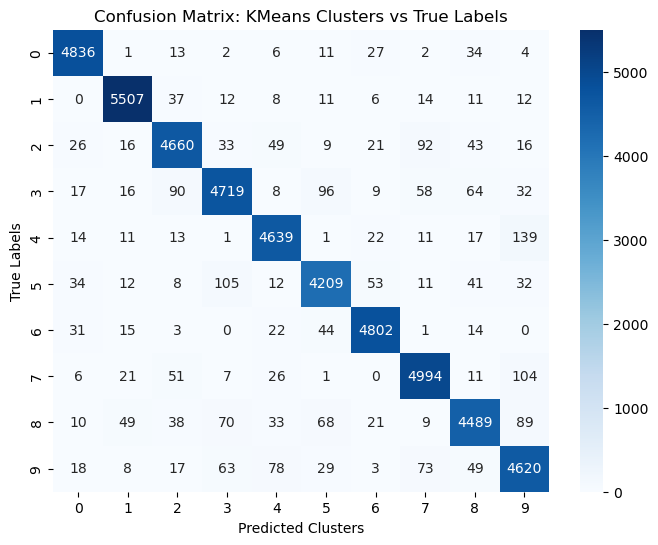

In [29]:
def plotConfusionMatrix(true_y, predicted_labels):
    conf_matrix = confusion_matrix(true_y, predicted_labels)

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix: KMeans Clusters vs True Labels")
    plt.xlabel("Predicted Clusters")
    plt.ylabel("True Labels")

plotConfusionMatrix(y_val, pipe_rf.predict(X_val))


### Evaluation metrics for classification problems

In [32]:
pipe_rf["rf"].get_params()['criterion']

'gini'

#### Gini impurity

Gini impurity is a measure of how often a randomly chosen element from the set would be incorrectly labeled if it were randomly labeled according to the distribution of labels in the subset. It's a measure of the "purity" of a node.

$$
Gini = 1 - \sum p_i^2
$$

where $p_i$ is the probability (proportion) of samples that belong to class $i$. For completely pure nodes, Gini impurity is 0. The maximum score is achieved when a node contains samples from all classes in equal proportions. Note the similarity to Gini index, a measure for economic inequality, also ranging between 0 and 1, and which reaches 0 at perfect equality when everyone has the same income.


#### Log-loss

An alternative measure is **log-loss (or cross-entropy)**. It can be understood intuitively as a measure of "surprise" about predictions. E.g., if you predict rain with 90% confidence, you feel minimal surprise if it indeed rains (low loss) while you would be very surprised if it doesn't rain (high loss). If you predict rain with 50%, either outcome comes with some surprise (medium loss).

$$
-\sum y_i \log(p_i)
$$

## Sklearn MLP

[This model optimizes the log-loss function using (...) stochastic gradient descent.](https://arc.net/l/quote/knlslrjn)

In [33]:
pipe_mlp = Pipeline([
    ("preprocess", FunctionTransformer(preprocessImageData)),
    ("mlp", MLPClassifier(random_state=prng))
])

pipe_mlp.fit(X_train, y_train)

train_accuracy = accuracy_score(pipe_mlp.predict(X_train), y_train)
test_accuracy = accuracy_score(pipe_mlp.predict(X_val), y_val)

results.add_model("Sklearn MLP", train_accuracy, test_accuracy)

,Train Accuracy,Test Accuracy
Logistic Regression,0.967,0.902
Logistic Regression with PCA,0.932,0.907
Random Forest,1.000,0.949
Random Forest with PCA,1.000,0.924
Sklearn MLP,1.000,0.955


In [34]:
pipe_mlp["mlp"].get_params()

{'activation': 'relu',
 'alpha': 0.0001,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (100,),
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'max_fun': 15000,
 'max_iter': 200,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': RandomState(MT19937) at 0x317860340,
 'shuffle': True,
 'solver': 'adam',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}

## Keras

While `scikit-learn` provides a wide range of machine learning algorithms, `keras` is specifically designed for building and training neural networks and deep learning models, making it more suitable for tasks involving complex patterns and large datasets. It offers several advanced features that `sklearn` does not, such as training networks with complex architectures (such as convolutional neural networks), or applying pre-processing techniques common to deep learning (such as scaling and flattening), or the ability to transfer learning from pre-trained networks.

Keras is a high-level neural network API that provides a simple and intuitive interface for building and training deep learning models. Keras can run on multiple backends, with TensorFlowTensor becoming the default. TensorFlow is a standalone, low-level deep learning library developed by Google.

In [35]:
from keras import __version__ as keras_version
print(keras_version)

3.9.0


In [36]:
from keras.utils import to_categorical

print(f"Dimension of y before transformation: {y_train.shape}")

# Convert target variables to categorical
num_classes = 10
y_sets = [y_train, y_test, y_val]
y_train, y_test, y_val = [to_categorical(y, num_classes=num_classes) for y in y_sets]
print(f"Dimension of y after transformation: {y_train.shape}")

Dimension of y before transformation: (10000,)
Dimension of y after transformation: (10000, 10)


### Simple model

In [37]:
from keras.models import Sequential
from keras.layers import Input, Flatten, Rescaling, Dense

x_sets = [X_train, X_test, X_val]
X_train, X_test, X_val = [Rescaling(1./255)(x) for x in x_sets]  # we will always need this from now on

# Build the model
model = Sequential([
    Input(shape=X_train.shape[1:]), 
    Flatten(),
    Dense(100, activation='relu'), 
    Dense(num_classes, activation='softmax')
])
print(model.summary())
# 784*100+100
# 100*10+10

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │        78,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,510 (310.59 KB)

 Trainable params: 79,510 (310.59 KB)

 Non-trainable params: 0 (0.00 B)

None


The core of the backend is indeed constructed around **tensors**. Tensors are akin to NumPy arrays, as they hold numerical values of different dimensions. What sets them apart is their specialized role in deep learning: they are equipped with built-in gradient computation, seamlessly integrate within a computational graph, and are capable of leveraging hardware accelerators like TPUs and GPUs.

In [ ]:
model.layers[2].output

In [38]:
# Fit the model
from keras.utils import set_random_seed
set_random_seed(20250324)  # for reproducibility
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=512)

Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4005 - loss: 1.9489 - val_accuracy: 0.7968 - val_loss: 0.8924
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8231 - loss: 0.7493 - val_accuracy: 0.8646 - val_loss: 0.5114
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8805 - loss: 0.4625 - val_accuracy: 0.8904 - val_loss: 0.4086
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9023 - loss: 0.3717 - val_accuracy: 0.9018 - val_loss: 0.3630
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9136 - loss: 0.3249 - val_accuracy: 0.9083 - val_loss: 0.3354
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9194 - loss: 0.2936 - val_accuracy: 0.9124 - val_loss: 0.3157
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9252 - loss: 0.2694 - val_accuracy: 0.9161 - val_loss: 0.3008
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9329 - loss: 0.2497 - val_accuracy: 0.9192 - val_loss:

In [40]:
# Evaluation of the model on the validation set
train_loss, train_accuracy = model.evaluate(X_train, y_train)
test_loss, test_accuracy = model.evaluate(X_val, y_val)
results.add_model("Keras MLP", train_accuracy, test_accuracy)


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - accuracy: 0.9448 - loss: 0.2133
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 381us/step - accuracy: 0.9229 - loss: 0.2734


,Train Accuracy,Test Accuracy
Logistic Regression,0.967,0.902
Logistic Regression with PCA,0.932,0.907
Random Forest,1.000,0.949
Random Forest with PCA,1.000,0.924
Sklearn MLP,1.000,0.955
Keras MLP,0.942,0.924


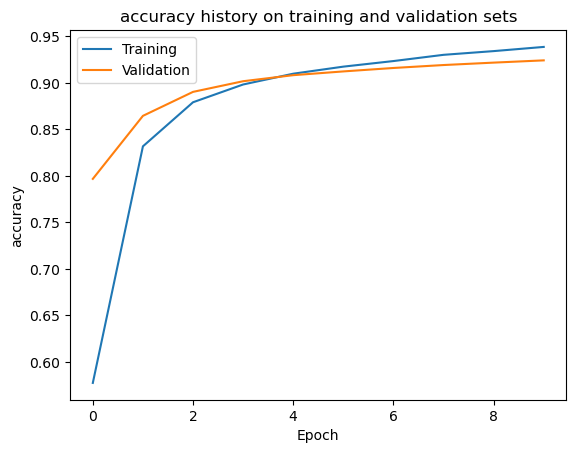

In [39]:
def plot_history(fit_history, metric="accuracy"):
    plt.plot(fit_history[metric], label='Training')
    plt.plot(fit_history[f'val_{metric}'], label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel(metric)
    plt.title(f'{metric} history on training and validation sets')
    plt.legend()
    plt.show()

plot_history(history.history)

It seems that the maximum is not yet found. Let's train the network a little bit longer. Note that unless we recreate the model, the process starts from the point where it previously ended.

In [41]:
# Run for at least 50 epochs, store the result in history_longer_train
history_longer_train = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=512)

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9449 - loss: 0.2056 - val_accuracy: 0.9262 - val_loss: 0.2625
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9486 - loss: 0.1941 - val_accuracy: 0.9277 - val_loss: 0.2556
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9523 - loss: 0.1836 - val_accuracy: 0.9293 - val_loss: 0.2493
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9547 - loss: 0.1740 - val_accuracy: 0.9308 - val_loss: 0.2435
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9571 - loss: 0.1652 - val_accuracy: 0.9324 - val_loss: 0.2382
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9594 - loss: 0.1570 - val_accuracy: 0.9338 - val_loss: 0.2333
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9617 - loss: 0.1494 - val_accuracy: 0.9351 - val_loss: 0.2288
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9634 - loss: 0.1423 - val_accuracy: 0.9361 - val_loss:

In [42]:
total_history = {
    "accuracy": history.history["accuracy"] + history_longer_train.history["accuracy"],
    "val_accuracy": history.history["val_accuracy"] + history_longer_train.history["val_accuracy"],
}

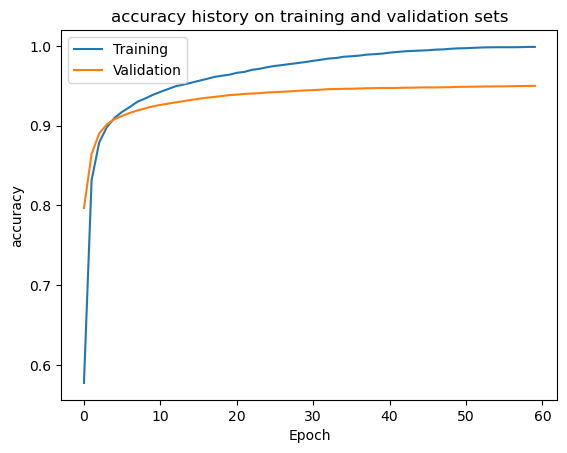

In [43]:
plot_history(total_history)

In [44]:
train_loss, train_accuracy = model.evaluate(X_train, y_train)
test_loss, test_accuracy = model.evaluate(X_val, y_val)
results.add_model("Keras MLP (longer training)", train_accuracy, test_accuracy)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - accuracy: 0.9991 - loss: 0.0209
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 364us/step - accuracy: 0.9490 - loss: 0.1864


,Train Accuracy,Test Accuracy
Logistic Regression,0.967,0.902
Logistic Regression with PCA,0.932,0.907
Random Forest,1.000,0.949
Random Forest with PCA,1.000,0.924
Sklearn MLP,1.000,0.955
Keras MLP,0.942,0.924
Keras MLP (longer training),0.999,0.950


### Regularization in neural networks

#### Early stopping

Keras' `EarlyStopping` method has a `patience` parameter which defines the number of epochs with no improvement after which training will be stopped. It defaults to 0.

In [45]:
from keras.callbacks import EarlyStopping
from keras.models import clone_model

# to make sure the process starts over, we need to create a new model instance and compile it
cloned_model = clone_model(model)
cloned_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# fit with early stopping
history_with_early_stopping = cloned_model.fit(
    X_train, y_train, validation_data=(X_val, y_val), epochs=200, batch_size=512, 
    callbacks=[EarlyStopping(monitor='val_accuracy')]
)

Epoch 1/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4070 - loss: 1.8921 - val_accuracy: 0.8054 - val_loss: 0.8432
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8281 - loss: 0.7119 - val_accuracy: 0.8670 - val_loss: 0.4996
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8805 - loss: 0.4537 - val_accuracy: 0.8898 - val_loss: 0.4057
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9030 - loss: 0.3682 - val_accuracy: 0.9010 - val_loss: 0.3631
Epoch 5/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9128 - loss: 0.3238 - val_accuracy: 0.9072 - val_loss: 0.3368
Epoch 6/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9197 - loss: 0.2941 - val_accuracy: 0.9121 - val_loss: 0.3186
Epoch 7/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9244 - loss: 0.2713 - val_accuracy: 0.9157 - val_loss: 0.3050
Epoch 8/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9302 - loss: 0.2524 - val_accuracy: 0.9187 - v

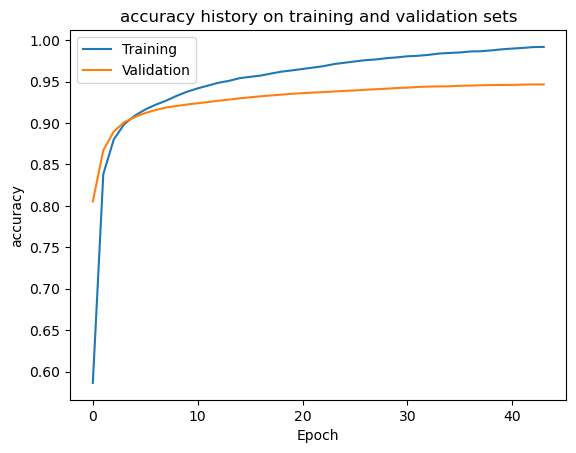

In [46]:
plot_history(history_with_early_stopping.history)

#### Dropout

The Dropout layer randomly sets input units to 0 with a frequency of `rate` at each step during training time, which helps prevent overfitting. Inputs not set to 0 are scaled up by 1 / (1 - `rate`) such that the sum over all inputs is unchanged.

In [52]:
from keras.layers import Dropout

# Build the model
reg_model = Sequential([
    Input(shape=X_train.shape[1:]),
    Flatten(),
    Dense(100, activation='relu'),
    Dropout(rate=0.5),
    Dense(num_classes, activation='softmax')
])

# Compile the model
reg_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(reg_model.summary())

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 100)            │        78,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,510 (310.59 KB)

 Trainable params: 79,510 (310.59 KB)

 Non-trainable params: 0 (0.00 B)

None


In [53]:
history_reg = reg_model.fit(
    X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=512,
    callbacks=[EarlyStopping(monitor='val_accuracy', patience=3)] # two epochs without any improvement is still fine
)

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2674 - loss: 2.0728 - val_accuracy: 0.7973 - val_loss: 1.0548
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6937 - loss: 1.0619 - val_accuracy: 0.8550 - val_loss: 0.6073
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7886 - loss: 0.7228 - val_accuracy: 0.8802 - val_loss: 0.4763
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8283 - loss: 0.5875 - val_accuracy: 0.8916 - val_loss: 0.4127
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8508 - loss: 0.5188 - val_accuracy: 0.9001 - val_loss: 0.3731
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8692 - loss: 0.4612 - val_accuracy: 0.9060 - val_loss: 0.3430
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8721 - loss: 0.4302 - val_accuracy: 0.9105 - val_loss: 0.3245
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8903 - loss: 0.3926 - val_accuracy: 0.9148 - 

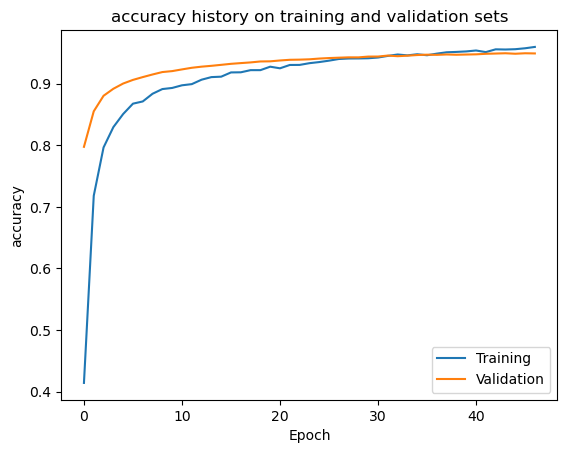

In [54]:
plot_history(history_reg.history)

In [55]:
train_loss, train_accuracy = regularized_model.evaluate(X_train, y_train)
test_loss, test_accuracy = regularized_model.evaluate(X_val, y_val)
results.add_model("Keras MLP (regularized)", train_accuracy, test_accuracy)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - accuracy: 0.9942 - loss: 0.0327
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 366us/step - accuracy: 0.9517 - loss: 0.1712


,Train Accuracy,Test Accuracy
Logistic Regression,0.967,0.902
Logistic Regression with PCA,0.932,0.907
Random Forest,1.000,0.949
Random Forest with PCA,1.000,0.924
Sklearn MLP,1.000,0.955
Keras MLP,0.942,0.924
Keras MLP (longer training),0.999,0.950
Keras MLP (regularized),0.994,0.952


### Deep network

**TODO**: Build a deeper network with at least two hidden layers. Train it and measure its performance. (Don't forget regularization!)

In [61]:
deep_model = Sequential([
    Input(shape=X_train.shape[1:]),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(rate=0.3),
    Dense(64, activation='relu'),
    Dropout(rate=0.3),
    Dense(32, activation='relu'),
    Dropout(rate=0.3),
    Dense(num_classes, activation='softmax')
])

# Compile the model
deep_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(deep_model.summary())

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_4 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,146 (434.16 KB)

 Trainable params: 111,146 (434.16 KB)

 Non-trainable params: 0 (0.00 B)

None


In [62]:
history_deep = deep_model.fit(
    X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=512,
    callbacks=[EarlyStopping(monitor='val_accuracy', patience=5)]
)

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.1903 - loss: 2.2168 - val_accuracy: 0.6131 - val_loss: 1.5276
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4527 - loss: 1.6357 - val_accuracy: 0.7945 - val_loss: 0.9265
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6121 - loss: 1.1792 - val_accuracy: 0.8575 - val_loss: 0.5988
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7254 - loss: 0.8777 - val_accuracy: 0.8840 - val_loss: 0.4418
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7977 - loss: 0.6991 - val_accuracy: 0.8954 - val_loss: 0.3717
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8237 - loss: 0.6095 - val_accuracy: 0.9076 - val_loss: 0.3279
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8501 - loss: 0.5252 - val_accuracy: 0.9135 - val_loss: 0.3035
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8643 - loss: 0.4676 - val_accuracy: 0.9180 - 

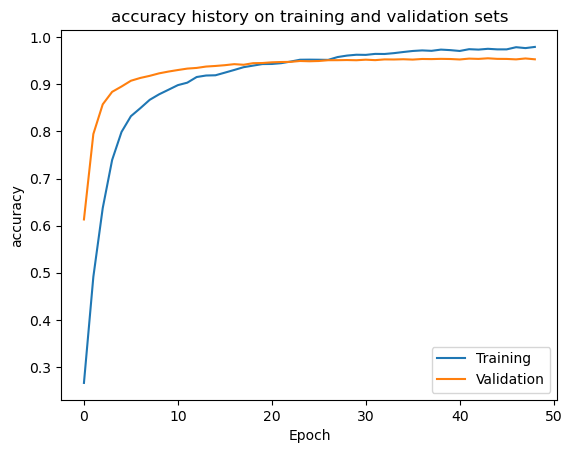

In [63]:
plot_history(history_deep.history)

In [64]:
train_loss, train_accuracy = deep_model.evaluate(X_train, y_train)
test_loss, test_accuracy = deep_model.evaluate(X_val, y_val)
results.add_model("Keras MLP (deep model)", train_accuracy, test_accuracy)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step - accuracy: 0.9973 - loss: 0.0108
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 384us/step - accuracy: 0.9529 - loss: 0.2193


,Train Accuracy,Test Accuracy
Logistic Regression,0.967,0.902
Logistic Regression with PCA,0.932,0.907
Random Forest,1.000,0.949
Random Forest with PCA,1.000,0.924
Sklearn MLP,1.000,0.955
Keras MLP,0.942,0.924
Keras MLP (longer training),0.999,0.950
Keras MLP (regularized),0.994,0.952
Keras MLP (deep model),0.998,0.953
